In [60]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [61]:
base_path = "/kaggle/input/food-segmentation-dataset-cvpr"
group_folders = [folder for folder in sorted(os.listdir(base_path)) if folder != "classes.json"]


In [62]:
# Loading data
def load_group_images(base_path, group):
    images, masks = [], []
    group_path = os.path.join(base_path, group)
    original_dir, mask_dir = sorted(os.listdir(group_path))

    image_files = sorted([f for f in os.listdir(os.path.join(group_path, original_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(os.path.join(group_path, mask_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(group_path, original_dir, img_file)
        mask_path = os.path.join(group_path, mask_dir, mask_file)

        img = load_img(img_path, target_size=(224, 224))
        mask = load_img(mask_path, target_size=(224, 224))

        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0

        images.append(img)
        masks.append(mask)

    return images, masks


In [63]:
def load_full_dataset(base_path, group_dirs):
    all_images, all_masks = [], []
    for group in group_dirs:
        imgs, msks = load_group_images(base_path, group)
        all_images.extend(imgs)
        all_masks.extend(msks)
    return all_images, all_masks

images, masks = load_full_dataset(base_path, group_folders)


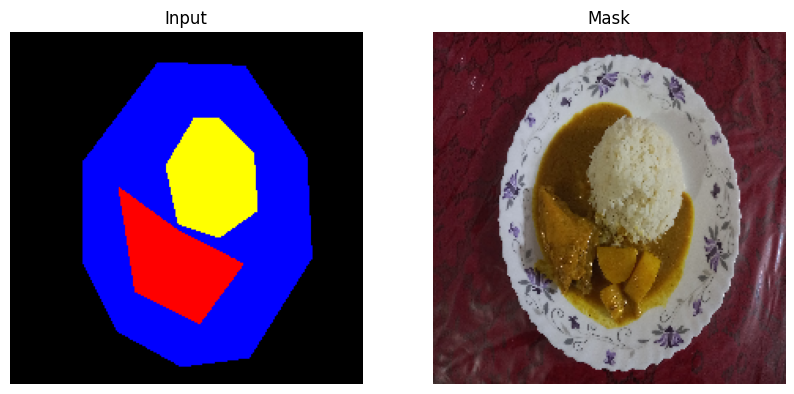

In [64]:
# Visualization
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Input")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[0])
plt.title("Mask")
plt.axis("off")
plt.show()


In [65]:
# Split 80:20
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, shuffle=True, random_state=42)


In [66]:
# Encoder block

def encoder_block(inp, num_filters, dropout_rate):
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, 1, activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [67]:
# Decoder block

def decoder_block(inp, skip_conn, num_filters, dropout_rate):
    x = UpSampling2D((2, 2))(inp)
    x = Concatenate()([x, skip_conn])
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(num_filters, 1, activation='relu', padding='same')(x)  # extra conv
    x = BatchNormalization()(x)
    return x


In [70]:
# Custom U-Net architecture

def build_segmentor(input_shape=(224, 224, 3), dropout=0.1):
    inp = Input(shape=input_shape)

    e1, p1 = encoder_block(inp, 32, dropout)
    e2, p2 = encoder_block(p1, 64, dropout)
    e3, p3 = encoder_block(p2, 128, dropout)
    e4, p4 = encoder_block(p3, 256, dropout)

    b = Conv2D(512, 3, activation='relu', padding='same')(p4)
    b = BatchNormalization()(b)
    b = Dropout(dropout)(b)
    b = Conv2D(512, 3, activation='relu', padding='same')(b)
    b = BatchNormalization()(b)

    d1 = decoder_block(b, e4, 256, dropout)
    d2 = decoder_block(d1, e3, 128, dropout)
    d3 = decoder_block(d2, e2, 64, dropout)
    d4 = decoder_block(d3, e1, 32, dropout)

    out = Conv2D(3, 1, activation='sigmoid')(d4)

    return Model(inputs=inp, outputs=out)

In [71]:
# Build and compile
model = build_segmentor()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Training
history = model.fit(np.array(X_train), np.array(y_train),
                    validation_data=(np.array(X_test), np.array(y_test)),
                    epochs=30, batch_size=8)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 224, 224, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 224, 224, 32)   │            128 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 224, 224, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 224, 224, 32)   │            128 │ conv2d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 224, 224, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 112, 112, 32)   │              0 │ dropout_23[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 112, 112, 64)   │            256 │ conv2d_53[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 112, 112, 64)   │            256 │ conv2d_54[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 112, 112, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 56, 56, 64)     │              0 │ dropout_24[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 56, 56, 128)    │            512 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)   

 Total params: 7,946,019 (30.31 MB)

 Trainable params: 7,940,131 (30.29 MB)

 Non-trainable params: 5,888 (23.00 KB)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3981 - loss: 0.7499 - val_accuracy: 0.2562 - val_loss: 0.9413
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5050 - loss: 0.6557 - val_accuracy: 0.1666 - val_loss: 1.0179
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.5722 - loss: 0.6570 - val_accuracy: 0.3241 - val_loss: 0.9883
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.5796 - loss: 0.6500 - val_accuracy: 0.3556 - val_loss: 1.0220
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.6114 - loss: 0.6469 - val_accuracy: 0.2220 - val_loss: 0.9014
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.6331 - loss: 0.6489 - val_accuracy: 0.3076 - val_loss: 0.9283
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.6378 - loss: 0.6533 - val_accuracy: 0.4931 - val_loss: 0.8240
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6397 - loss: 0.6498 - val_accuracy: 0.23

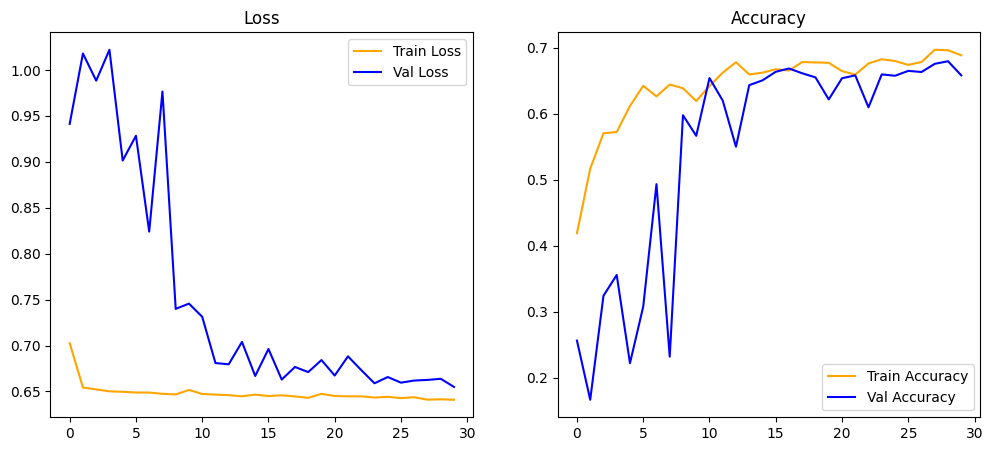

In [73]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.plot(history.history['val_loss'], label='Val Loss', color='blue')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='orange')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.title("Accuracy")
plt.legend()
plt.show()

In [74]:
# Predictions
predictions = model.predict(np.array(X_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


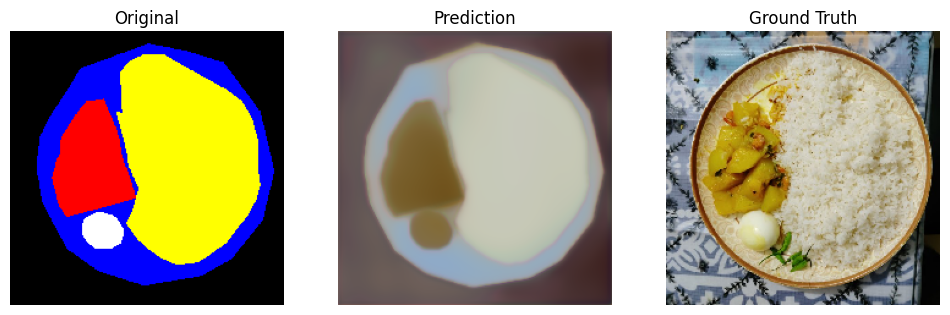

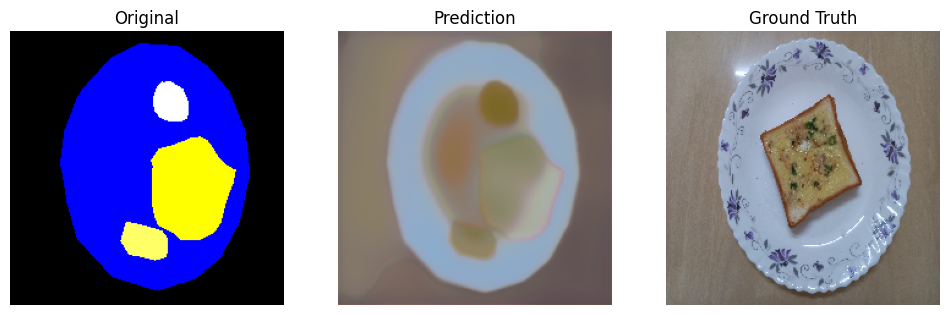

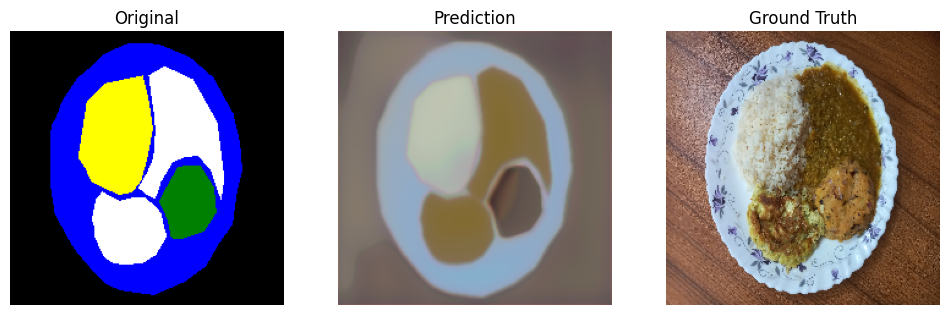

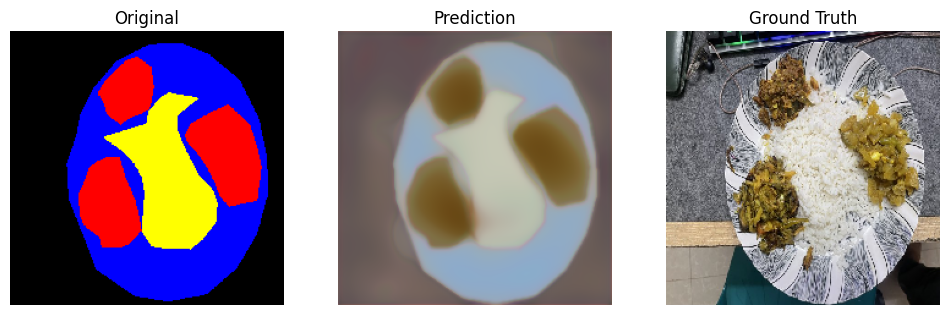

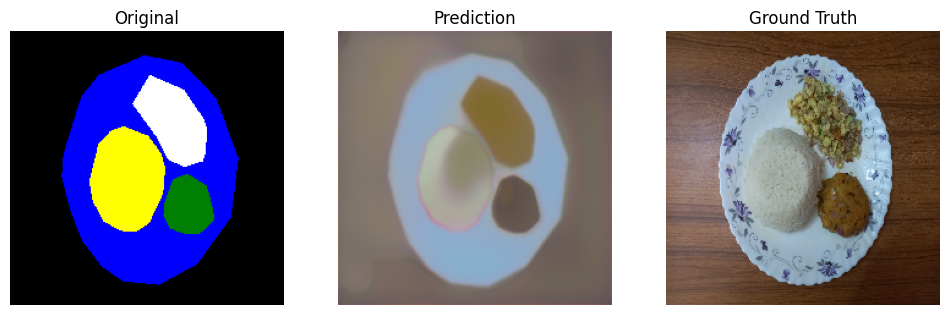

In [75]:
# Visualizing results

def show_segmentation_result(index):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    ax[0].imshow(X_test[index])
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(predictions[index])
    ax[1].set_title("Prediction")
    ax[1].axis("off")

    ax[2].imshow(y_test[index])
    ax[2].set_title("Ground Truth")
    ax[2].axis("off")
    plt.show()

for i in range(5):
    show_segmentation_result(i)